In [0]:
 from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
#RUN

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

import torchvision.datasets as dsets
from skimage import transform
import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader
import random;
import math;
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
from torchvision import models
from torch.optim import lr_scheduler
import time
# Visualize the results on PCA-reduced data
from time import time
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [0]:
#Read the images and ground_truth from drive

#RUN

Fold_1 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_1.mat')
Fold_2 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_2.mat')
Fold_3 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_3.mat')
Fold_4 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_4.mat')
Fold_5 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_5.mat')

fold_1 = Fold_1['Fold_1']
fold_2 = Fold_2['Fold_2']
fold_3 = Fold_3['Fold_3']
fold_4 = Fold_4['Fold_4']
fold_5 = Fold_5['Fold_5']


In [0]:
#RUN
def get_5_fold(index_4, index_1):
    x = [None]*5
    y = [None]*5
    t = [None]*5
    x[0] = fold_1[:,0]
    x[1] = fold_2[:,0]
    x[2] = fold_3[:,0]
    x[3] = fold_4[:,0]
    x[4] = fold_5[:,0]

    y[0] = fold_1[:,1:(512*512)+ 1]
    y[1] = fold_2[:,1:(512*512)+ 1]
    y[2] = fold_3[:,1:(512*512)+ 1]
    y[3] = fold_4[:,1:(512*512)+ 1]
    y[4] = fold_5[:,1:(512*512)+ 1]

    t[0] = fold_1[:,(512*512)+ 1:2*(512*512)+ 1]
    t[1] = fold_2[:,(512*512)+ 1:2*(512*512)+ 1]
    t[2] = fold_3[:,(512*512)+ 1:2*(512*512)+ 1]
    t[3] = fold_4[:,(512*512)+ 1:2*(512*512)+ 1]
    t[4] = fold_5[:,(512*512)+ 1:2*(512*512)+ 1]

    labels_train = np.concatenate([x[index_4[0]], x[index_4[1]], x[index_4[2]], x[index_4[3]]], 0)
    images_train = np.concatenate([y[index_4[0]], y[index_4[1]], y[index_4[2]], y[index_4[3]]], 0)
    masks_train = np.concatenate([t[index_4[0]], t[index_4[1]], t[index_4[2]], t[index_4[3]]], 0)

    labels_test = x[index_1[0]]
    images_test = y[index_1[0]]
    masks_test = t[index_1[0]]
    del x,y,t
    return labels_train, images_train, masks_train, labels_test, images_test, masks_test

In [0]:
#RUN

# Realize 5-fold cross-validation
from itertools import combinations 
  
# Get all combinations of [1, 2, 3, 4, 5] 
# and length 4
comb = combinations([0, 1, 2, 3, 4], 4) 
comb = list(comb)

#Choose a combination from 0..4
ind = 1
res = [ele  for ele in range(5) if ele   not in comb[ind]] 

#Print first 4-fold indexex for train, and 1-fold index for test
print('Indexes for train: ', comb[ind])
print('Index for test', res)

labels_train, images_train, masks_train, labels_test, images_test, masks_test = get_5_fold(comb[ind], res)
#depend on batch_size


Indexes for train:  (0, 1, 2, 4)
Index for test [3]


In [0]:
#RUN
# Choose l1 and l2 depending on batch_size, and 5_fold generation
# batch should divide de size
# Here I hard coded the values for train and test, depending on folders that I have selected for train and test
l = [[2400, 630], [2430, 600], [2460, 570], [2370, 630], [2490, 540]]
l1 = [[1650, 450]]

CHOOSE = l

size_train_loader = CHOOSE[ind][0]
size_test_loader = CHOOSE[ind][1]

labels_train = labels_train[0:size_train_loader]
images_train = images_train[0:size_train_loader, :]
masks_train = masks_train[0:size_train_loader, :]

labels_test = labels_test[0:size_test_loader]
images_test = images_test[0:size_test_loader, :]
masks_test = masks_test[0:size_test_loader, :]

print(labels_train.shape, images_train.shape, masks_train.shape)
print(labels_test.shape, images_test.shape, masks_test.shape)



(2430,) (2430, 262144) (2430, 262144)
(600,) (600, 262144) (600, 262144)


In [0]:
#RUN to permute data
from sklearn.utils import shuffle

shuffle_labels_train, shuffle_images_train, shuffle_mask_train = shuffle(labels_train, images_train, masks_train, random_state=0)
shuffle_labels_test, shuffle_images_test, shuffle_mask_test = shuffle(labels_test, images_test, masks_test, random_state=0)



In [0]:
print(shuffle_labels_train.shape, shuffle_images_train.shape, shuffle_mask_train.shape)


(2430,) (2430, 262144) (2430, 262144)


In [0]:
#RUN
#free RAM, because session will crash
%reset_selective -f Fold_1
%reset_selective -f Fold_2
%reset_selective -f Fold_3
%reset_selective -f Fold_4
%reset_selective -f Fold_5

In [0]:
# Count the number of unique labels in fold
unique, counts = np.unique(shuffle_labels_train, return_counts=True)
uniquee, countss = np.unique(shuffle_labels_test, return_counts=True)
print(counts, countss)


[ 583 1096  751] [124 312 164]


In [0]:
shuffle_labels_train = torch.from_numpy(shuffle_labels_train)
shuffle_images_train = torch.from_numpy(shuffle_images_train)
shuffle_mask_train = torch.from_numpy(shuffle_mask_train)

shuffle_labels_test = torch.from_numpy(shuffle_labels_test)
shuffle_images_test = torch.from_numpy(shuffle_images_test)
shuffle_mask_test = torch.from_numpy(shuffle_mask_test)

In [0]:
#Compute mean and std dev for train set

mean_tr = (shuffle_images_train.float().mean())
std_tr = (shuffle_images_train.float().std())
print(mean_tr, std_tr)

tensor(460.0681) tensor(635.6172)


In [0]:
class BrainDataset(Dataset):
    '''Brain Dataset'''
    def __init__(self, t_x, t_m, t_y, ratio, size, mean, std, transform=None):
        self.X         = t_x
        self.Y         = t_y
        self.M         = t_m
        self.ratio     = ratio
        self.size      = size
        self.transform = transform
        self.mean      = mean
        self.std       = std
    def __len__(self):
        return len(self.X);
      
    def transformm(self, image, mask):

        # Random horizontal flipping
        image = transforms.ToPILImage()(image)
        mask = transforms.ToPILImage()(mask)
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
            
        if random.random() > 0.5:
            rotation = random.randint(15, 45)
            image = TF.rotate(image, rotation)
            mask = TF.rotate(mask, rotation)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask

    
    def __getitem__(self, idx):
        item = self.X[idx];
        label = self.Y[idx];
        mask = self.M[idx]
        #imaginea 512x512 o transform in size x size
        #image 512x512 will become 512/ratio x 512//ratio for optimize memory
        
        item = item.view(-1, 512)
        item = item[0:512:self.ratio,0:512:self.ratio]
                
        mask = mask.view(-1, 512)
        mask = mask[0:512:self.ratio,0:512:self.ratio]
        
        item = item.float()
        
        if self.transform == 1:   
          item, mask = self.transformm(np.float32(item.view(-1, self.size)), np.float32(mask.view(-1, self.size)))
        else:
          mask = transforms.ToPILImage()(np.float32(mask.view(-1, self.size)))
          item = transforms.ToPILImage()(np.float32(item.view(-1, self.size)))
          mask = TF.to_tensor(mask)
          item = TF.to_tensor(item)
        return (item, mask, label)

In [0]:
#RUN
batch_size = 30
ratio = 4 #how much we reduce from 1 dimension of image. Ex. ratio = 2 => 256x256 image , ratio = 4 => 512x512
size_image = 128 #Dimmension by dividing height and weight to ratio

train_dataset = BrainDataset(shuffle_images_train, shuffle_mask_train, shuffle_labels_train, ratio, size_image, mean_tr, std_tr, transform = 0)
test_dataset = BrainDataset(shuffle_images_test, shuffle_mask_test, shuffle_labels_test, ratio, size_image, mean_tr, std_tr, transform = 0)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           );
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          );
##########




2430
tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 4.,  6.,  7.,  ...,  7.,  8.,  6.],
         [ 9., 16., 12.,  ..., 14., 14., 17.],
         ...,
         [12., 16., 17.,  ..., 11., 22., 17.],
         [10., 18., 16.,  ..., 18., 22., 11.],
         [ 3.,  5.,  6.,  ...,  6.,  5.,  4.]]])
tensor(3, dtype=torch.int16)


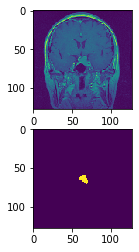

600


In [0]:
#RUN to test if data is normalized, and mask is correlated with image
#Printez sa vad daca s-a normalizat
#Print values from an image to see if values are normalized
print(train_dataset.__len__())
t, m, l = train_dataset.__getitem__(0)
#print(t[0][100])
print(t)
print(l)

plt.figure(1)
plt.subplot(211)
plt.imshow(t[0])

plt.subplot(212)
plt.imshow(m[0])
plt.show()

print(test_dataset.__len__())

In [0]:
# Library to extract GLCM, GLRLM features from image

%pip install pyradiomics

     |████████████████████████████████| 163kB 4.9MB/s 
     |████████████████████████████████| 42.5MB 71kB/s 
     |████████████████████████████████| 40kB 5.6MB/s 
     |████████████████████████████████| 4.4MB 39.9MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: PyWavelets 1.1.1
    Uninstalling PyWavelets-1.1.1:
      Successfully uninstalled PyWavelets-1.1.1


In [0]:
from radiomics import firstorder, glcm, imageoperations, shape, glrlm, glszm, getTestCase
import SimpleITK as sitk
import six
import sys, os

In [0]:
#Extract GLCM features

feature_per_image =  np.zeros(shape=(25))
feature_train_glcm = np.zeros(shape=(train_dataset.__len__(), 25))
feature_test_glcm  = np.zeros(shape=(test_dataset.__len__(), 25))

for i in range(0, train_dataset.__len__()):
  im, ma, label = train_dataset.__getitem__(i)
  image = sitk.GetImageFromArray(im)
  mask = sitk.GetImageFromArray(ma)
  firstOrderFeatures = glcm.RadiomicsGLCM(image,mask)
  firstOrderFeatures.enableAllFeatures()  # On the feature class level, all features are disabled by default.
  firstOrderFeatures.execute()
  feature_per_image[0] = label
  
  j = 1
  for (key,val) in six.iteritems(firstOrderFeatures.featureValues):
    feature_per_image[j] = val
    j += 1

  feature_train_glcm[i] = feature_per_image

for i in range(0, test_dataset.__len__()):
  im, ma, label = test_dataset.__getitem__(i)
  image = sitk.GetImageFromArray(im)
  mask = sitk.GetImageFromArray(ma)
  firstOrderFeatures = glcm.RadiomicsGLCM(image,mask)
  firstOrderFeatures.enableAllFeatures()  # On the feature class level, all features are disabled by default.
  firstOrderFeatures.execute()
  feature_per_image[0] = label
  
  j = 1
  for (key,val) in six.iteritems(firstOrderFeatures.featureValues):
    feature_per_image[j] = val
    j += 1

  feature_test_glcm[i] = feature_per_image

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [0]:
#Extract GLRLM features

feature_per_image =  np.zeros(shape=(17))
feature_train_glrlm = np.zeros(shape=(train_dataset.__len__(), 17))
feature_test_glrlm  = np.zeros(shape=(test_dataset.__len__(), 17))

for i in range(0, train_dataset.__len__()):
  im, ma, label = train_dataset.__getitem__(i)
  image = sitk.GetImageFromArray(im)
  mask = sitk.GetImageFromArray(ma)
  firstOrderFeatures = glrlm.RadiomicsGLRLM(image,mask)
  firstOrderFeatures.enableAllFeatures()  # On the feature class level, all features are disabled by default.
  firstOrderFeatures.execute()
  feature_per_image[0] = label
  
  j = 1
  for (key,val) in six.iteritems(firstOrderFeatures.featureValues):
    feature_per_image[j] = val
    j += 1

  feature_train_glrlm[i] = feature_per_image

for i in range(0, test_dataset.__len__()):
  im, ma, label = test_dataset.__getitem__(i)
  image = sitk.GetImageFromArray(im)
  mask = sitk.GetImageFromArray(ma)
  firstOrderFeatures = glrlm.RadiomicsGLRLM(image,mask)
  firstOrderFeatures.enableAllFeatures()  # On the feature class level, all features are disabled by default.
  firstOrderFeatures.execute()
  feature_per_image[0] = label
  
  j = 1
  for (key,val) in six.iteritems(firstOrderFeatures.featureValues):
    feature_per_image[j] = val
    j += 1

  feature_test_glrlm[i] = feature_per_image


print(feature_test_glrlm[0][0])


2.0


In [0]:
# Concatenate GLCM and GLRLM features

feature_train_glcm_glrlm = np.concatenate((feature_train_glcm , feature_train_glrlm[:, 1:] ), axis = 1)
feature_test_glcm_glrlm = np.concatenate((feature_test_glcm , feature_test_glrlm[:, 1:] ), axis = 1)



In [0]:
class GetFeatures:
    '''Brain Dataset'''
    def __init__(self, train, test, mode):
        self.Train  = train
        self.Test   = test
        self.mode   = mode
      
    def __len__(self):
        return len(self.X);
    
    def train_test_set(self):
      if self.mode == 'extract':
        X_train = self.Train[:, 1:]
        Y_train = self.Train[:, 0]
        X_test  = self.Test[:, 1:]
        Y_test  = self.Test[:, 0]
      else:
        X_train = []
        Y_train = []
        X_test  = []
        Y_test  = []

        for i in range(0, train_dataset.__len__()):
            im, ma, label = train_dataset.__getitem__(i)
            im = (im - mean_tr)/std_tr

            X_train.append(im)
            Y_train.append(label)
        for i in range(0, test_dataset.__len__()):
            im, ma, label = test_dataset.__getitem__(i)
            X_test.append(im)
            Y_test.append(label)

        X_train = [t.numpy() for t in X_train]
        Y_train = [t.numpy() for t in Y_train]
        X_test  = [t.numpy() for t in X_test]
        Y_test  = [t.numpy() for t in Y_test]

        X_train = np.asarray(X_train)
        Y_train = np.asarray(Y_train)
        X_test = np.asarray(X_test)
        Y_test = np.asarray(Y_test)

        X_train = np.reshape(X_train, (-1, 128*128))
        X_test  = np.reshape(X_test, (-1, 128*128))
        

      return (X_train, Y_train, X_test, Y_test)

In [0]:
getFeatures = GetFeatures(feature_train_glcm, feature_test_glcm, 'extract')
getFeatures = GetFeatures(feature_train_glrlm, feature_test_glrlm, 'extract')
getFeatures = GetFeatures(feature_train_glcm_glrlm, feature_test_glcm_glrlm, 'extract')

X_train, Y_train, X_test, Y_test = getFeatures.train_test_set()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Y_train = Y_train - 1
Y_train = Y_train.astype(int)
Y_test  = Y_test - 1
Y_test = Y_test.astype(int)

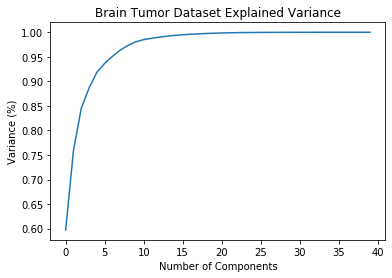

In [0]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(np.concatenate((X_train, X_test), axis = 0))#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Brain Tumor Dataset Explained Variance')
plt.show()

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import adjusted_rand_score

kmeans = KMeans(n_clusters=3, max_iter = 600) # You want cluster the passenger records into 2: Survived or Not survived
kmeans.fit(X_train)

y_pred = kmeans.labels_
y_pred_test = kmeans.predict(X_test)

In [0]:
reduced_data = PCA(n_components=10).fit_transform(np.concatenate((X_train, X_test), axis=0))

X_trainn = reduced_data[0:2430,:]
X_testt  = reduced_data[2430:,:]

kmeans1 = KMeans(n_clusters=3, max_iter = 600) # You want cluster the passenger records into 2: Survived or Not survived
kmeans1.fit(X_trainn)

y_pred_PCA = kmeans1.labels_
y_pred_test_PCA = kmeans1.predict(X_testt)

In [0]:
from sklearn.cluster import AgglomerativeClustering

ward1 = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(X_train)
y_pred_H = ward1.labels_

ward2 = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(X_trainn)
y_pred_H_PCA = ward2.labels_


indices = calculate_mapping(y_pred_H, Y_train)
print(calculate_accuracy(indices, y_pred_H, Y_train))

indices = calculate_mapping(y_pred_H_PCA, Y_train)
print(calculate_accuracy(indices, y_pred_H_PCA, Y_train))

0.5580246913580247
0.5320987654320988


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [0]:
def to_codebook(X, part):
    """
    Calculates centroids according to flat cluster assignment

    Parameters
    ----------
    X : array, (n, d)
        The n original observations with d features

    part : array, (n)
        Partition vector. p[n]=c is the cluster assigned to observation n

    Returns
    -------
    codebook : array, (k, d)
        Returns a k x d codebook with k centroids
    """
    codebook = []

    for i in range(part.min(), part.max()+1):
        codebook.append(X[part == i].mean(0))

    return np.vstack(codebook)

In [0]:
hc_clusters_H = to_codebook(X_train, y_pred_H)
hc_clusters_H_PCA = to_codebook(X_trainn, y_pred_H_PCA)

kmeans.cluster_centers_ = hc_clusters_H
y_pred_test_H = kmeans.predict(X_test)

kmeans.cluster_centers_ = hc_clusters_H_PCA
y_pred_test_H_PCA = kmeans.predict(X_testt)

In [0]:
from sklearn.manifold import TSNE

tsne_ter = TSNE(n_components=3, random_state=0, perplexity=40)#, init='pca')
X_tsne_ter = tsne_ter.fit_transform(X_train)
xtsne_t = pd.DataFrame(X_tsne_ter)
X_tsne_test =tsne_ter.fit_transform(X_test)
xtsne_t_test = pd.DataFrame(X_tsne_test)



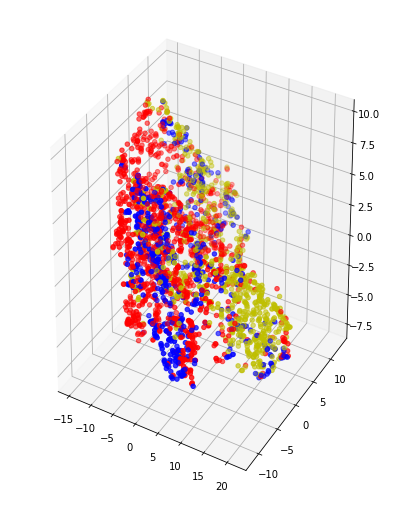

In [0]:
xtsne_t['label'] = Y_train

from mpl_toolkits.mplot3d import Axes3D
Axes3D
c_map = {0:'b', 1:'r', 2:'y'}
fig = plt.figure(figsize = (40,20))
ax = fig.add_subplot(251,projection='3d')
ax.scatter(xs=xtsne_t[0],ys=xtsne_t[1],zs=xtsne_t[2], c=[c_map[_] for _ in xtsne_t['label']])
plt.show()

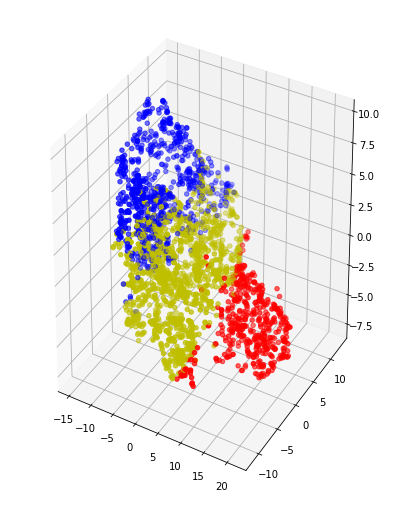

In [0]:
xtsne_t['label'] = y_pred_PCA

from mpl_toolkits.mplot3d import Axes3D
Axes3D
c_map = {0:'b', 1:'r', 2:'y'}
fig = plt.figure(figsize = (40,20))
ax = fig.add_subplot(251,projection='3d')
ax.scatter(xs=xtsne_t[0],ys=xtsne_t[1],zs=xtsne_t[2], c=[c_map[_] for _ in xtsne_t['label']])
plt.show()

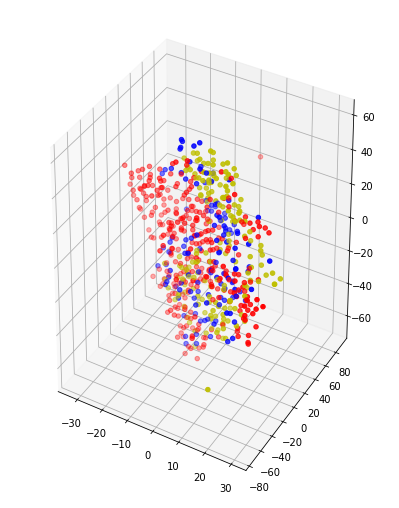

In [0]:
xtsne_t_test['label'] = Y_test

from mpl_toolkits.mplot3d import Axes3D
Axes3D
c_map = {0:'b', 1:'r', 2:'y'}
fig = plt.figure(figsize = (40,20))
ax = fig.add_subplot(251,projection='3d')
ax.scatter(xs=xtsne_t_test[0],ys=xtsne_t_test[1],zs=xtsne_t_test[2], c=[c_map[_] for _ in xtsne_t_test['label']])
plt.show()

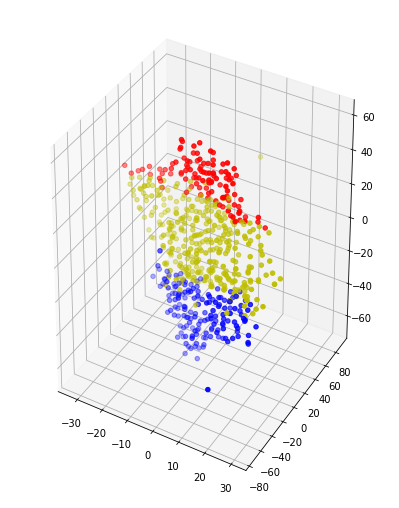

In [0]:
xtsne_t_test['label'] = y_pred_test_PCA

from mpl_toolkits.mplot3d import Axes3D
Axes3D
c_map = {0:'b', 1:'r', 2:'y'}
fig = plt.figure(figsize = (40,20))
ax = fig.add_subplot(251,projection='3d')
ax.scatter(xs=xtsne_t_test[0],ys=xtsne_t_test[1],zs=xtsne_t_test[2], c=[c_map[_] for _ in xtsne_t_test['label']])
plt.show()

In [0]:
from scipy.optimize import linear_sum_assignment 
from sklearn.utils.linear_assignment_ import linear_assignment

def calculate_mapping(ypred, y):
    """
    Calculating the clustering accuracy. The predicted result must have the same number of clusters as the ground truth.
    
    ypred: 1-D numpy vector, predicted labels
    y: 1-D numpy vector, ground truth
    The problem of finding the best permutation to calculate the clustering accuracy is a linear assignment problem.
    This function construct a N-by-N cost matrix, then pass it to scipy.optimize.linear_sum_assignment to solve the assignment problem.
    
    """
    assert len(y) > 0
    assert len(np.unique(ypred)) == len(np.unique(y))
    
    s = np.unique(ypred)
    t = np.unique(y)
    
    N = len(np.unique(ypred))
    C = np.zeros((N, N), dtype = np.int32)
    for i in range(N):
        for j in range(N):
            idx = np.logical_and(ypred == s[i], y == t[j])
            C[i][j] = np.count_nonzero(idx)
    
    # convert the C matrix to the 'true' cost
    Cmax = np.amax(C)
    C = Cmax - C
    # 
    indices = linear_assignment(C)
    return indices
def calculate_accuracy(indices, ypred, y):
    
    assert len(y) > 0
    assert len(np.unique(ypred)) == len(np.unique(y))
        
    s = np.unique(ypred)
    t = np.unique(y)

    N = len(np.unique(ypred))

    row = indices[:][:, 0]
    col = indices[:][:, 1]
    # calculating the accuracy according to the optimal assignment
    count = 0
    for i in range(N):
        idx = np.logical_and(ypred == s[row[i]], y == t[col[i]] )
        count += np.count_nonzero(idx)
    
    return 1.0*count/len(y)

indices = calculate_mapping(y_pred, Y_train)
print(calculate_accuracy(indices, y_pred, Y_train))
print(calculate_accuracy(indices, y_pred_test, Y_test))

indices = calculate_mapping(y_pred_PCA, Y_train)
print(calculate_accuracy(indices, y_pred_PCA, Y_train))
print(calculate_accuracy(indices, y_pred_test_PCA, Y_test))

print('--------------------------------------------------')

indices = calculate_mapping(y_pred_H, Y_train)
print(calculate_accuracy(indices, y_pred_H, Y_train))
print(calculate_accuracy(indices, y_pred_test_H, Y_test))

indices = calculate_mapping(y_pred_H_PCA, Y_train)
print(calculate_accuracy(indices, y_pred_H_PCA, Y_train))
print(calculate_accuracy(indices, y_pred_test_H_PCA, Y_test))

#GLCM PCA 0.44583333333333336 0.5285714285714286 | 0.44625 0.5285714285714286
# GLRLM PCA 0.43916666666666665 0.49206349206349204 | 0.4395833333333333 0.
#GLCM + GLRLM PCA 0.44958333333333333 0.5285714285714286 | 0.45125 0.5317460317460317

#GLCM + GLRLM 0.4806584362139918 0.3616666666666667 | 0.4823045267489712 0.3616666666666667

#GLCM + GLRLM PCA 0.55802469135802470.42333333333333334 | 0.5320987654320988 0.4216666666666667

0.47983539094650207
0.365
0.4806584362139918
0.36333333333333334
--------------------------------------------------
0.5580246913580247
0.42333333333333334
0.5320987654320988
0.4216666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


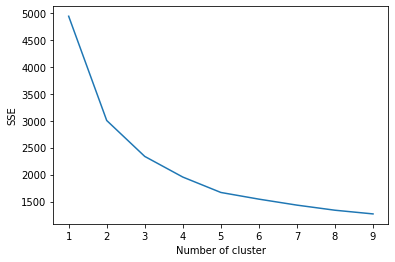

In [0]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=5000).fit(X_train)
    # data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()